In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
# sys.path.append('/home/jovyan/work/GitHub/EvanPys/Progress')
sys.path.append(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress')
from ADlasso2 import AD2_w_utils_lossdiff as ad

## B cells

In [2]:
import json

with open('B_tuning.json') as f:
    tuning = json.load(f)


FileNotFoundError: [Errno 2] No such file or directory: 'B_tuning.json'

In [ ]:
celltype = 'B'
tuning_df = pd.read_csv(f'{celltype}_tuning_df.csv')
print(tuning_df.shape)
tuning_df.tail()

In [ ]:
opt_lmbd, fig = ad.lambda_decision(tuning_df, k=2, savepath=f'./lambda_decision/{celltype}_lambda_decision.png')
print('Optimal lambda:', opt_lmbd)

In [ ]:
# plot feature number
Fig = ad.lambda_tuning_viz(tuning_df, 'Feature_number', savepath=f'{celltype}_feature_number.png')

## DC cells

In [ ]:
celltype = 'DC'
tuning_df = pd.read_csv(f'{celltype}_tuning_df.csv')
print(tuning_df.shape)
Fig = ad.lambda_tuning_viz(tuning_df, 'Feature_number', savepath=f'{celltype}_feature_number.png')

In [ ]:
with open(f'{celltype}_tuning.json') as f:
    tuning = json.load(f)

tuning_old_format = {}
for outer_key in tuning.keys():
    for inner_key, value in tuning[outer_key].items():
        if inner_key not in tuning_old_format.keys():
            tuning_old_format[inner_key] = []
        tuning_old_format[inner_key].append(value)
for key in tuning_old_format.keys():
    tuning_old_format[key] = np.array(tuning_old_format[key])

Fig = ad.lambda_tuning_viz(tuning_old_format, 'Feature_number', savepath=f'{celltype}_feature_number3.png')

In [ ]:
opt_lmbd, fig = ad.lambda_decision(tuning_df, k=2, savepath=f'./lambda_decision/{celltype}_lambda_decision.png')
print('Optimal lambda:', opt_lmbd)

In [ ]:
opt_lmbd, fig = ad.lambda_decision(tuning_old_format, k=2, savepath=f'./lambda_decision/{celltype}_lambda_decision2.png')
print('Optimal lambda:', opt_lmbd)

In [ ]:

def ignore_section_lambda_decision(celltype, last_idx):
    print('====================')
    print(f'Cell type: {celltype}')
    with open(f'{celltype}_tuning.json') as f:
        tuning = json.load(f)
        for k in tuning.keys():
            tuning[k] = np.array(tuning[k])
    
    trimmed_tuning = {}
    for k in tuning.keys():
        trimmed_tuning[k] = tuning[k][:last_idx+1]
    
    # Lambda decision from trimmed tuning result
    opt_lmbd, fig = ad.lambda_decision(trimmed_tuning, k=2, savepath=f'./log_analyze_outcome/{celltype}_lambda_decision.png')
    print('Optimal lambda:', opt_lmbd)
    log_opt_lmbd = np.log(opt_lmbd)

    log_lambda_range = tuning['log_lambda_range']
    opt_idx = np.where(log_lambda_range == log_opt_lmbd)[0][0]

    feature_no_celltype = int(tuning['Feature_number'][opt_idx])
    print('Feature no:', feature_no_celltype)

    # Plot lambda vs. prevalence and lambda vs. loss
    plot_lambda_decision(tuning, celltype, opt_lmbd, last_idx+1, savepath=f'./log_analyze_outcome/{celltype}_lambda_decision_all.png')
    
    return opt_lmbd, feature_no_celltype

## Ignore section lambda decision
(Feature 數量為零之後的lambda就不要了)

In [3]:
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao\Level1_loss_difference\tuning_result")

In [4]:
def ignore_section_lambda_decision(tuning_dict, celltype, version='new', output_dir=''):
    if version == 'new':
        # convert tuning_dict to old format
        tuning_old_format = {}
        for outer_key in tuning_dict.keys():
            for inner_key, value in tuning_dict[outer_key].items():
                if inner_key not in tuning_old_format.keys():
                    tuning_old_format[inner_key] = []
                tuning_old_format[inner_key].append(value)
    else:
        tuning_old_format = tuning_dict

    for key in tuning_old_format.keys():
        tuning_old_format[key] = np.array(tuning_old_format[key])
        
    # Find the index of feature_number start to become 0
    cut_idx = len(tuning_old_format['Feature_number'])
    for i in range(len(tuning_old_format['Feature_number'])):
        if tuning_old_format['Feature_number'][i] == 0:
            cut_idx = i
            print(cut_idx)
            break

    trimmed_tuning = {}
    for k in tuning_old_format.keys():
        trimmed_tuning[k] = tuning_old_format[k][:cut_idx]

    def plot_lambda_decision(tuning, celltype, opt_lmbd, cut_idx, savepath=''):
        fig, ax1 = plt.subplots(figsize = (8, 5))
        ax2 = ax1.twinx()

        line1, = ax1.plot(np.exp(tuning['log_lambda_range']), tuning['loss_history'], marker='o', color='blue')
        line2, = ax2.plot(np.exp(tuning['log_lambda_range']), tuning['Feature_number'], marker='o', color='orange')
        ax1.set(xscale="log")

        # vertical line for optimal lambda
        plt.axvline(x=opt_lmbd, color = 'black', linestyle=':')
        
        if cut_idx < len(tuning['log_lambda_range']):
            # only plot the cut line when the cut_idx is not the last index
            print('Cut:', np.exp(tuning['log_lambda_range'][cut_idx]))
            # vertical line for cut lambda
            plt.axvline(x=np.exp(tuning['log_lambda_range'][cut_idx]), color = 'red', linestyle=':')
        
        # horizontal line for feature number = 0
        plt.axhline(y=0, color = 'black', linestyle='--')

        ax1.set_xlabel(f"lambda (optimal: {opt_lmbd})")
        ax1.set_ylabel("Loss"); ax2.set_ylabel("Feature number")
        ax2.set_yscale("log")
        ax2.set_ylim(bottom=0.5, top=None)
        ax1.set_title(f'{celltype} lambda decision')
        plt.legend(handles=[line1, line2], labels=['BCE loss', 'Feature_number'], loc='upper left')

        if savepath:
            plt.savefig(savepath, dpi=300)

    # Lambda decision from trimmed tuning result
    opt_lmbd, fig = ad.lambda_decision(trimmed_tuning, k=2, savepath=output_dir + f'{celltype}_lambda_decision_trimmed.png')
    print('Optimal lambda:', opt_lmbd)
    log_opt_lmbd = np.log(opt_lmbd)

    log_lambda_range = tuning_old_format['log_lambda_range']
    opt_idx = np.where(log_lambda_range == log_opt_lmbd)[0][0]

    feature_no_celltype = int(tuning_old_format['Feature_number'][opt_idx])
    print('Feature no:', feature_no_celltype)

    # Plot lambda vs. prevalence and lambda vs. loss
    plot_lambda_decision(tuning_old_format, celltype, opt_lmbd, cut_idx, savepath=output_dir + f'{celltype}_lambda_decision_all.png')

    return opt_lmbd, feature_no_celltype

In [5]:
opt_lmbd_dict = {}
feature_no_dict = {}


Cell type: B
24
Optimal lambda: 0.006812920690579613
Feature no: 13
Cut: 0.10000000000000002
Cell type: CD4_T
Optimal lambda: 0.0010000000000000002
Feature no: 181
Cell type: CD8_T
Optimal lambda: 0.004641588833612781
Feature no: 16
Cell type: DC
20
Optimal lambda: 0.0010000000000000002
Feature no: 34
Cut: 0.02154434690031885
Cell type: Mono
Optimal lambda: 0.006812920690579613
Feature no: 22
Cell type: NK
Optimal lambda: 0.004641588833612781
Feature no: 34


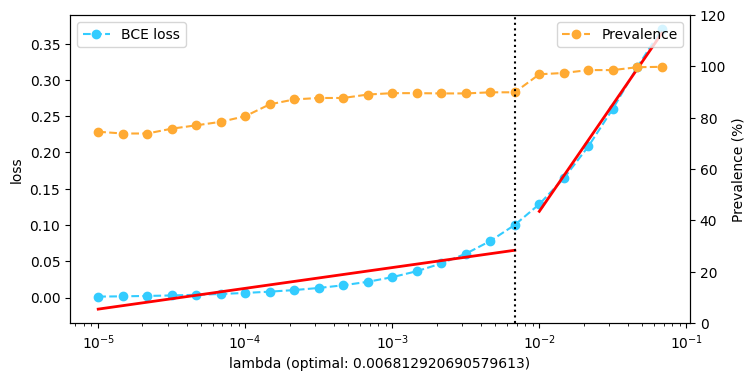

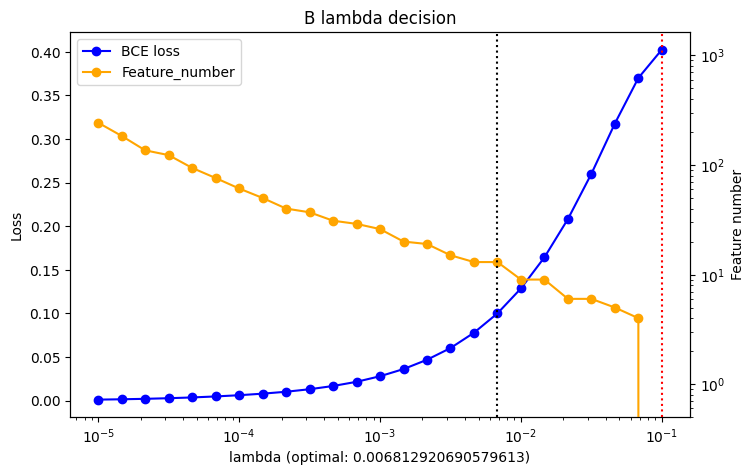

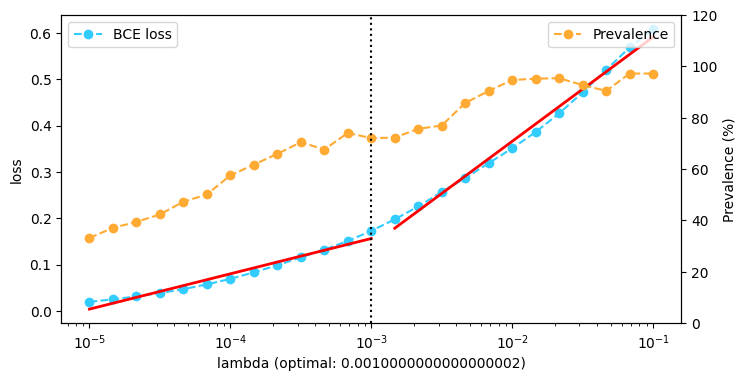

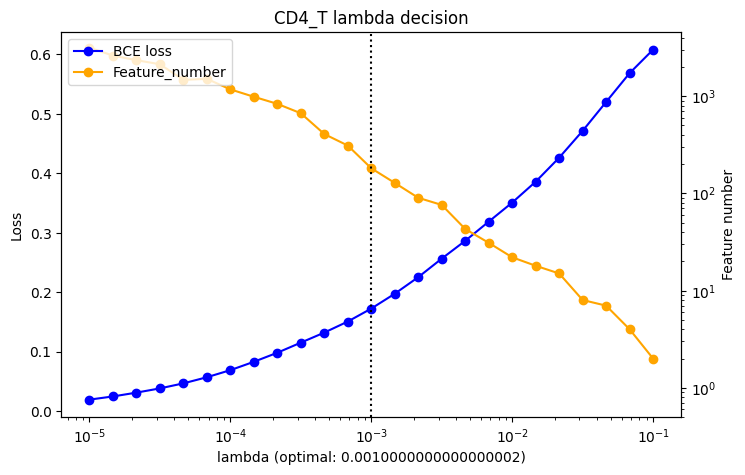

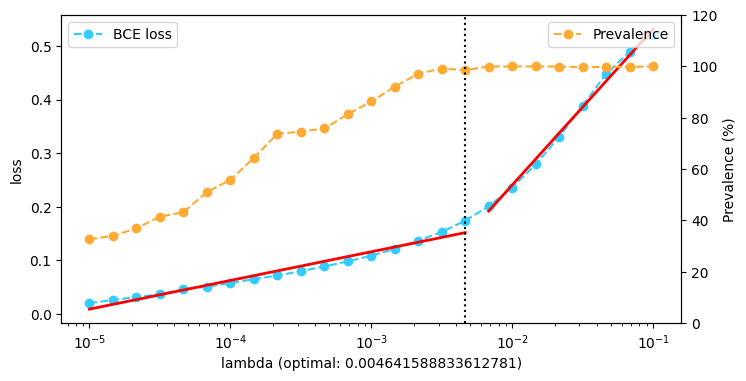

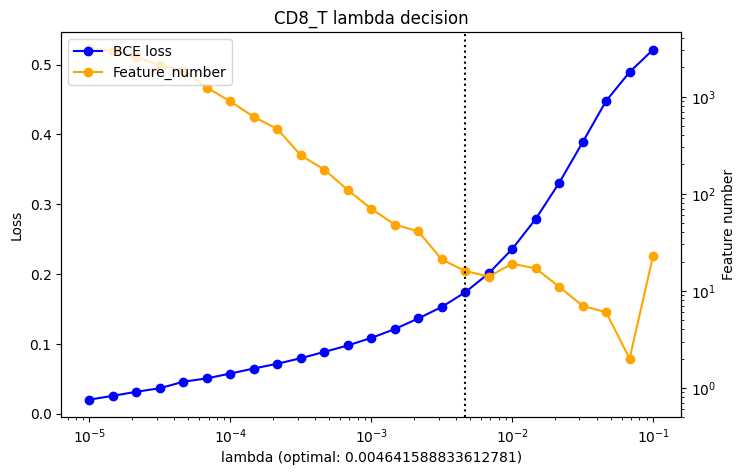

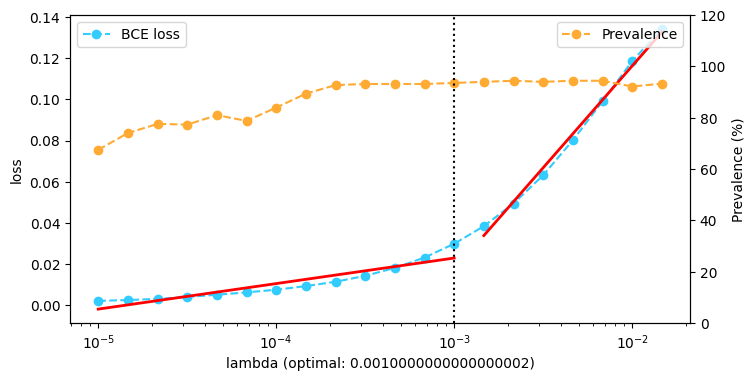

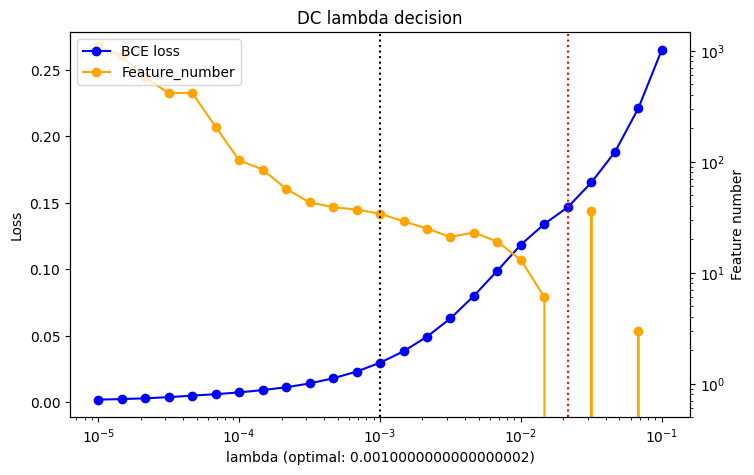

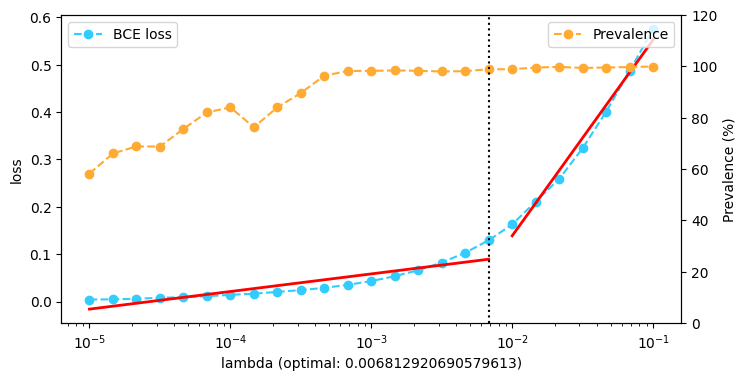

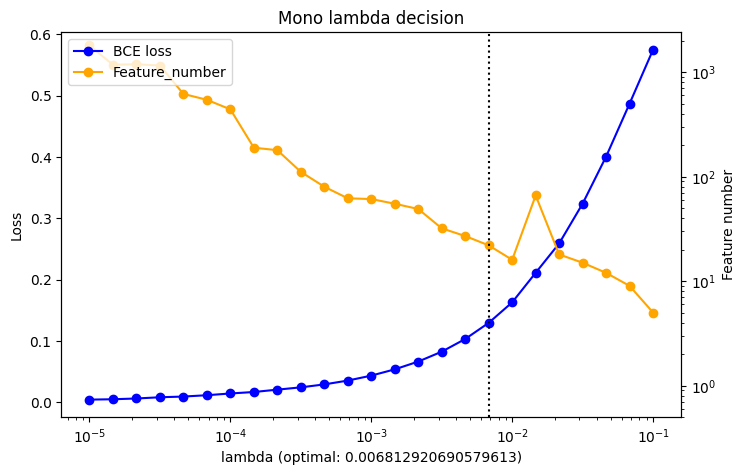

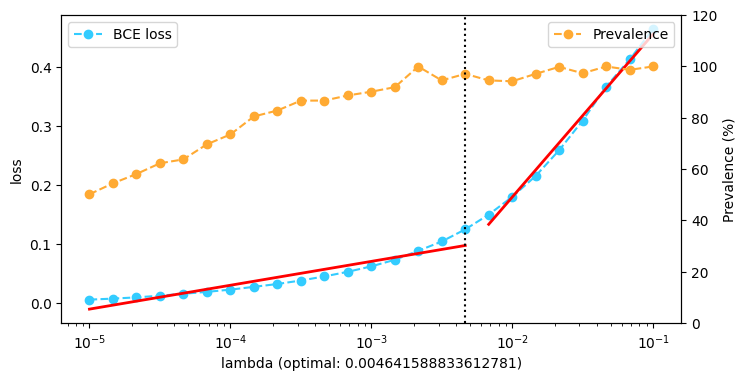

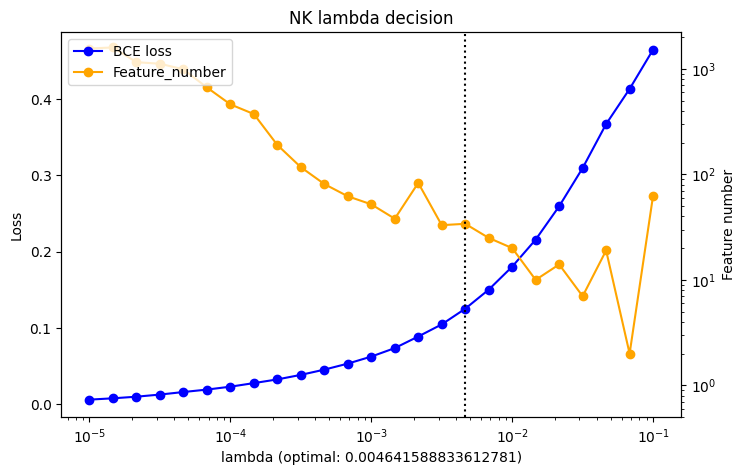

In [6]:
cts = ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']
new = ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK']
for celltype in new:
    print('====================')
    print(f'Cell type: {celltype}')
    with open(f'{celltype}_tuning.json') as f:
        tuning = json.load(f)

    output_dir = r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao\Level1_loss_difference" + "\\"
    opt_lmbd, feature_no_celltype = ignore_section_lambda_decision(tuning, celltype, version='new', output_dir=output_dir)
    opt_lmbd_dict[celltype] = opt_lmbd
    feature_no_dict[celltype] = feature_no_celltype

Cell type: other
21
Optimal lambda: 0.003162277660168382
Feature no: 7
Cut: 0.0316227766016838
Cell type: other_T
23
Optimal lambda: 0.0010000000000000002
Feature no: 68
Cut: 0.0681292069057962


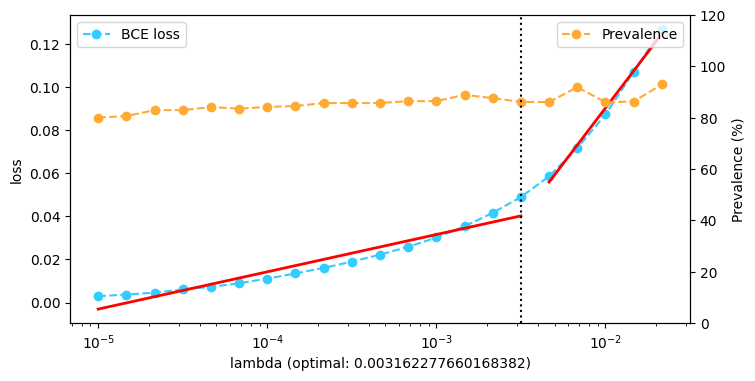

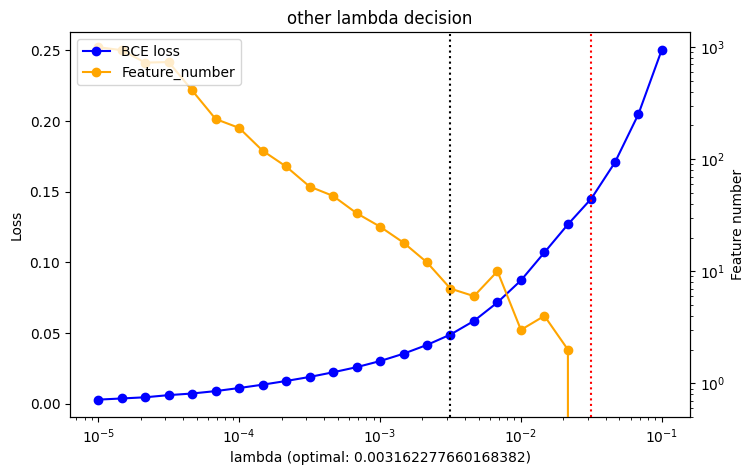

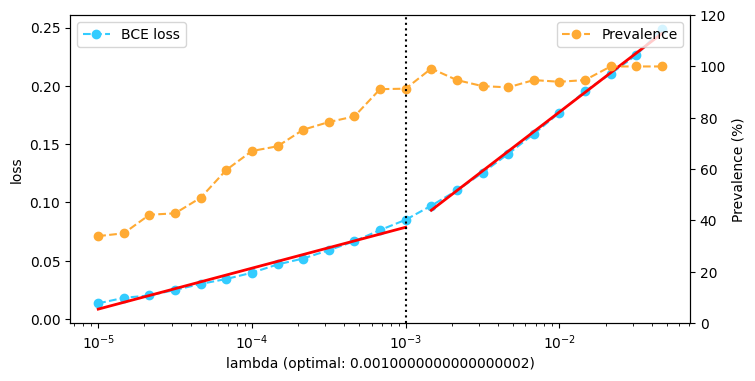

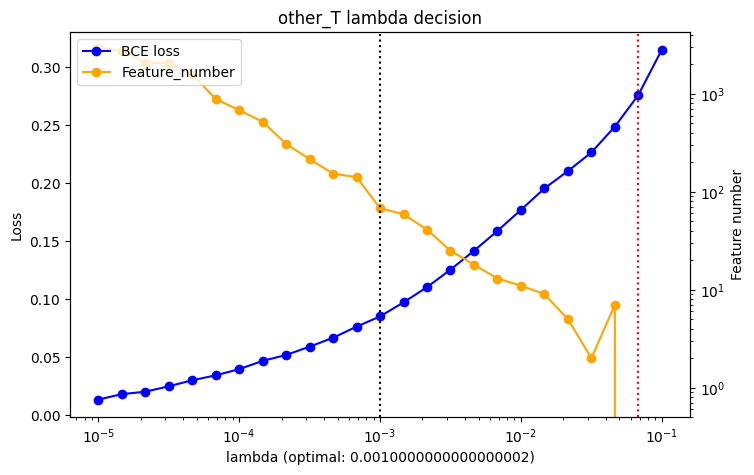

In [7]:
old = ['other', 'other_T']
for celltype in old:
    print('====================')
    print(f'Cell type: {celltype}')
    with open(f'{celltype}_tuning.json') as f:
        tuning = json.load(f)

    output_dir = r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao\Level1_loss_difference" + "\\"
    opt_lmbd, feature_no_celltype = ignore_section_lambda_decision(tuning, celltype, version='old', output_dir=output_dir)
    opt_lmbd_dict[celltype] = opt_lmbd
    feature_no_dict[celltype] = feature_no_celltype

In [8]:
opt_lmbd_dict

{'B': 0.006812920690579613,
 'CD4_T': 0.0010000000000000002,
 'CD8_T': 0.004641588833612781,
 'DC': 0.0010000000000000002,
 'Mono': 0.006812920690579613,
 'NK': 0.004641588833612781,
 'other': 0.003162277660168382,
 'other_T': 0.0010000000000000002}

In [9]:
feature_no_dict

{'B': 13,
 'CD4_T': 181,
 'CD8_T': 16,
 'DC': 34,
 'Mono': 22,
 'NK': 34,
 'other': 7,
 'other_T': 68}

In [10]:
with open('L1_loss_diff_opt_lmbd.json', 'w') as f:
    json.dump(opt_lmbd_dict, f)

In [11]:
# import json
# opt_lmbd_dict = {'B': 0.006812920690579613,
#  'CD4_T': 0.0010000000000000002,
#  'CD8_T': 0.004641588833612781,
#  'DC': 0.0010000000000000002,
#  'Mono': 0.006812920690579613,
#  'NK': 0.004641588833612781,
#  'other': 0.003162277660168382,
#  'other_T': 0.0010000000000000002}

# with open('L1_loss_diff_opt_lmbd.json', 'w') as f:
#     json.dump(opt_lmbd_dict, f)

## Plot feature number

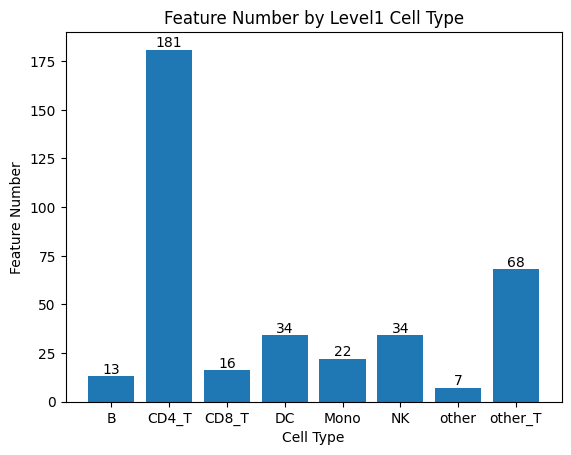

In [12]:
import matplotlib.pyplot as plt

# Extract the cell types and feature numbers from the dictionary
cell_types = list(feature_no_dict.keys())
feature_numbers = list(feature_no_dict.values())

# Create a bar plot
plt.bar(cell_types, feature_numbers)

# Add labels for the y-values on top of each bar
for i, v in enumerate(feature_numbers):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.xlabel('Cell Type')
plt.ylabel('Feature Number')
plt.title('Feature Number by Level1 Cell Type')

# Display the plot
plt.show()
